# OCR
 

## Imports

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd
import metric_orthograph as mo
import matplotlib.pyplot as plt


# initialisation des variables globales
rss.init()



2023-02-22 12:02:43.856 INFO    root: TensorFlow version 2.10.0 available.


In [36]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)
reload(mo)

<module 'metric_orthograph' from 'd:\\GitHub\\OCRpyMAN\\notebooks\\metric_orthograph.py'>

# Utility

# Code

## Text detection

In [4]:
form_img_path = '../data/formsA-D/a01-000u.png'
form_img = plt.imread(form_img_path)
img_size = (form_img.shape[0], form_img.shape[1])

doctr_bboxes = mdl.get_image_bounding_boxes(form_img_path)
bounding_boxes = mdl.format_bounding_boxes(doctr_bboxes, img_size)
bounding_boxes_xyhw = mdl.format_bounding_boxes_xyhw(doctr_bboxes, img_size)

2023-02-22 12:02:49.309 INFO    root: Using downloaded & verified file: C:\Users\TiBo\.cache\doctr\models\db_resnet50-adcafc63.zip
2023-02-22 12:02:52.394 INFO    root: Using downloaded & verified file: C:\Users\TiBo\.cache\doctr\models\crnn_vgg16_bn-76b7f2c6.zip


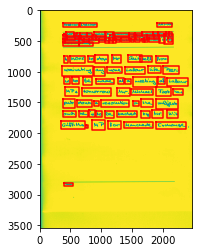

In [5]:
form_img = plt.imread(form_img_path)
size = form_img.shape[0], form_img.shape[1]
# plot_bounding_boxes_xyhw(bounding_boxes_xyhw)
mdl.plot_bounding_boxes(bounding_boxes)
plt.imshow(form_img)
plt.show()

### Testing with an image stream

In [6]:
# straight_model = load_text_detection_model()

# form_img_path = '../data/formsA-D/a01-000u.png'
# form_img = plt.imread(form_img_path)

# doc = DocumentFile.from_images(bytearray(form_img))
# doctr_coords = straight_model.det_predictor(doc)[0]
# doctr_coords

### Test with cropping

In [7]:
img_path = '../data/formsA-D/a01-000u.png'
doctr_bboxes = mdl.get_image_bounding_boxes(img_path)
img_arr = mdl.load_image(img_path)
img_size = (img_arr.shape[0], img_arr.shape[1])

bounding_boxes = mdl.format_bounding_boxes(doctr_bboxes, (1,1))
bounding_boxes_xyhw = mdl.format_bounding_boxes_xyhw(doctr_bboxes, (1,1))

2023-02-22 12:03:00.137 INFO    root: Using downloaded & verified file: C:\Users\TiBo\.cache\doctr\models\db_resnet50-adcafc63.zip
2023-02-22 12:03:02.488 INFO    root: Using downloaded & verified file: C:\Users\TiBo\.cache\doctr\models\crnn_vgg16_bn-76b7f2c6.zip


In [8]:
def reorder_bounding_boxes_coords():
    return []
bboxes = [[0.7919921875, 0.162109375,0.0146484375, 0.0546875,]]
list(map(lambda bbox: [bbox[1], bbox[0], bbox[2], bbox[3]], bboxes))

[[0.162109375, 0.7919921875, 0.0146484375, 0.0546875]]

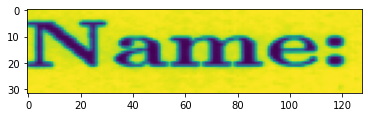

In [9]:
bboxes = [bounding_boxes[0]]
# bboxes = [bounding_boxes_xyhw[0]]
crops = tf.image.crop_and_resize(
    tf.expand_dims(img_arr, 0),
    boxes=list(map(lambda bbox: [bbox[1], bbox[0], bbox[3], bbox[2]], bboxes)),
    # boxes=bboxes,
    crop_size=[32, 128], # To resize the crop (32, 128)
    box_indices=list(range(len(bboxes)))
)

for crop in crops:
    plt.imshow(crop)
    plt.plot()

### Multiple

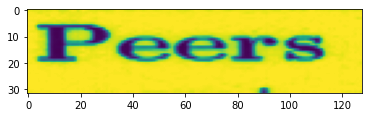

In [10]:
bboxes = bounding_boxes
crops = tf.image.crop_and_resize(
    tf.expand_dims(img_arr, 0),
    boxes=list(map(lambda bbox: [bbox[1], bbox[0], bbox[3], bbox[2]], bboxes)), # [y1, x1, y2, x2]
    crop_size=[32, 128], # To resize the crop img to (32, 128)
    box_indices=[0 for i in range(len(bboxes))] # We are always using the same img
)

# fig = plt.figure(figsize = (10,20))
# nb_figs = len(crops)
# for i in range(nb_figs):
#     fig.add_subplot(1,nb_figs, i+1)
#     plt.imshow(crops[i])
# plt.plot()

i=0
for crop in crops[0: len(crops) - 5]:
    i += 1
    if i < 3:
        continue
    plt.imshow(crop)
    plt.plot()

## Text recognition

### POC

In [11]:
df = pd.read_pickle('../pickle/df.pickle')

[]

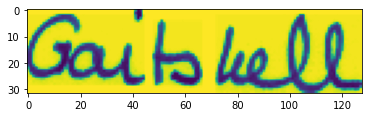

In [12]:
word_img_path = df.iloc[5].word_img_path
word_img = mdl.load_image(word_img_path, (32, 128));
plt.imshow(word_img);
plt.plot()

In [13]:
np.array([word_img]).shape

(1, 32, 128, 1)

In [14]:
reco_model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})

In [15]:
# reco_predictions = reco_model.predict(np.array([word_img]))
reco_predictions = reco_model.predict(
    np.array(word_img).reshape(1,word_img.shape[0],word_img.shape[1],1)
)

C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 226ms/step


In [16]:
mots = ld_util.greedy_decoder(reco_predictions, rss.charList)
print(mots)

['']


# Full model

2023-02-22 17:26:34.061 INFO    root: Using downloaded & verified file: C:\Users\TiBo\.cache\doctr\models\db_resnet50-adcafc63.zip
2023-02-22 17:26:37.016 INFO    root: Using downloaded & verified file: C:\Users\TiBo\.cache\doctr\models\crnn_vgg16_bn-76b7f2c6.zip
C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 1s 464ms/step


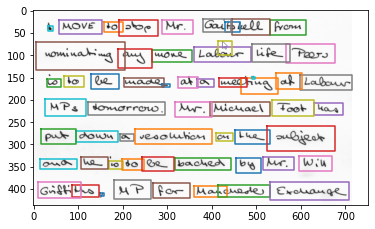

[['.', 'move', 'to', 'stop', 'Mr.', 'Gait', 'tol', 'shell', 'from', 'uouinatig-', 'any', 'more', 'Labour', 'Do', 'life', 'Peers', 'to', 'be', 'at', '.', 'af', 'Labour', 'Ps', 'o', 'made', '-', 'a', 'meer', 'thing', 'Foot', 'tomorrow', 'Mr.', 'Michael', 'has', 'put', 'down', 'a', 'resolution', 'n', 'the', 'subject', 'and', 'he', 'o', 'to', 'be', 'backed', 'by', 'Mr.', 'wil', 'Griffin', 'its', 'p', 'for', 'Mane', 'poster', 'Range', ',']]


In [50]:
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)
reload(mo)


text_detection_model = mdl.load_text_detection_model()
text_reco_model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})

form_img_path = '../data/formsA-D/a01-000u.png'
form_img_path = "D:/tmp/test.png"

text = mdl.make_ocr(text_detection_model, text_reco_model, form_img_path, True)
print(text)